## Lab: Modeling Time Series Data

#### Scenario

As a junior data scientist at AirGo Analytics, your role is to build a forecasting model for airline passenger trends. In the previous lab, you explored the dataset, detected trends and seasonality, and applied transformations to prepare the data for modeling. Now, your goal is to develop an ARIMA (AutoRegressive Integrated Moving Average) model to predict airline passenger traffic for the next 12 months.

The forecasting process involves selecting ARIMA parameters using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, fitting the model, and evaluating its accuracy using error metrics such as MAE and RMSE. This reflects a common industry challenge in which businesses rely on time series forecasting to inform decisions about resource allocation, pricing strategies, and operational planning.



### Step 0: Load and Prepare the Dataset
* Import necessary libraries.
* Load 'AirPassengers.csv' and inspect the data.

In [71]:
# CodeGrade step0

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
data = pd.read_csv('AirPassengers.csv')

# Look at the data
data.head()

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


### Step 1: Convert the Data to a Time Series Format
* Convert the time column to datetime format.
* Set the Month column as the index.
* Rename value to `Passengers`.
* Set Month as the index and define its frequency as 'MS'.
 * To make sure this runs corrrectly, do this both in 'pd.data_range' and 'data.index.freq'.
* Verify by checking a specific value, viz. the first value using '.iloc'. (Round this to two decimal places.)

In [72]:
# CodeGrade step1

# Convert to DataFrame and set index
data['Month'] = pd.to_datetime(dict(
    year=np.floor(data['time']).astype(int),
    month=((data['time'] - np.floor(data['time']))*12).round().astype(int) + 1,
    day=1
))

data = data.rename(columns={'value': 'Passengers'}).set_index('Month').sort_index()
data.index = pd.date_range(start=data.index.min(), periods=len(data), freq='MS')
data.index.freq = 'MS'

# verify
round(float(data['Passengers'].iloc[0]), 2)

112.0

### Step 2: Transform and Visualize the Data
* Apply log transformation to stabilize variance.
* Perform first-order differencing to remove trends.
* Display the dataset shape after transformation.

In [73]:
# CodeGrade step2

# Log Transformation
data['Log_Passengers'] = np.log(data['Passengers'])

# Differencing (first order)
data['Diff_1'] = data['Log_Passengers'].diff()

print(data.dropna().shape)


(143, 4)


Plot ACF and PACF to determine ARIMA parameters.

<Figure size 800x400 with 0 Axes>

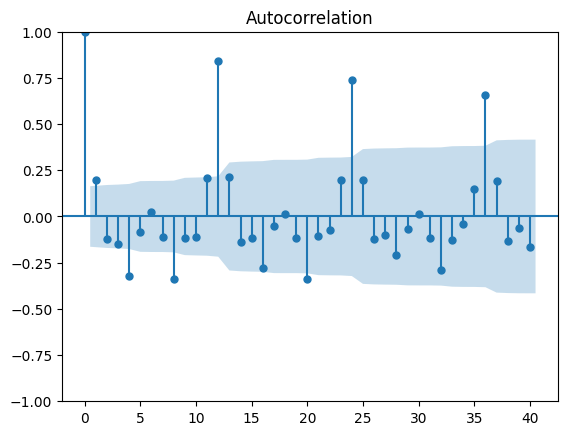

<Figure size 800x400 with 0 Axes>

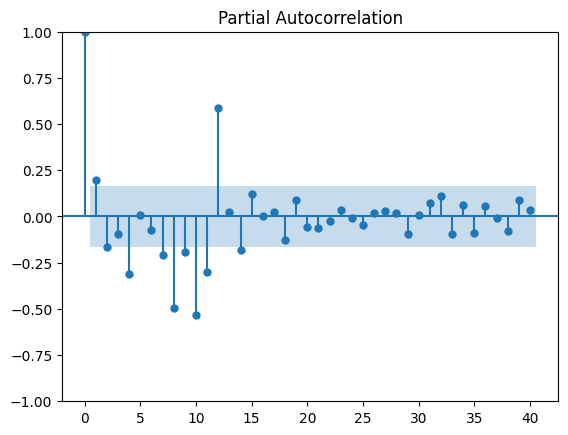

In [74]:
# ACF and PACF plots

plt.figure(figsize=(8,4))
plot_acf(data['Diff_1'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(8,4))
plot_pacf(data['Diff_1'].dropna(), lags=40, method='ywm')
plt.show()


### Step 3: Fit an ARIMA Model
* Define and train an ARIMA (2,1,2) model based on ACF/PACF insights.
* Compute Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) for model evaluation.
 * Return these valiues as 'aic, bic', where they are both rounded to 1 decimal places

In [75]:
# CodeGrade step3

# Define and fit ARIMA model
model = ARIMA(data['Log_Passengers'], order=(2, 1, 2),
              enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

# Print model summary
aic = round(float(model_fit.aic), 1)
bic = round(float(model_fit.bic), 1)



Plot Model Diagnostics to analyze residuals and model fit.

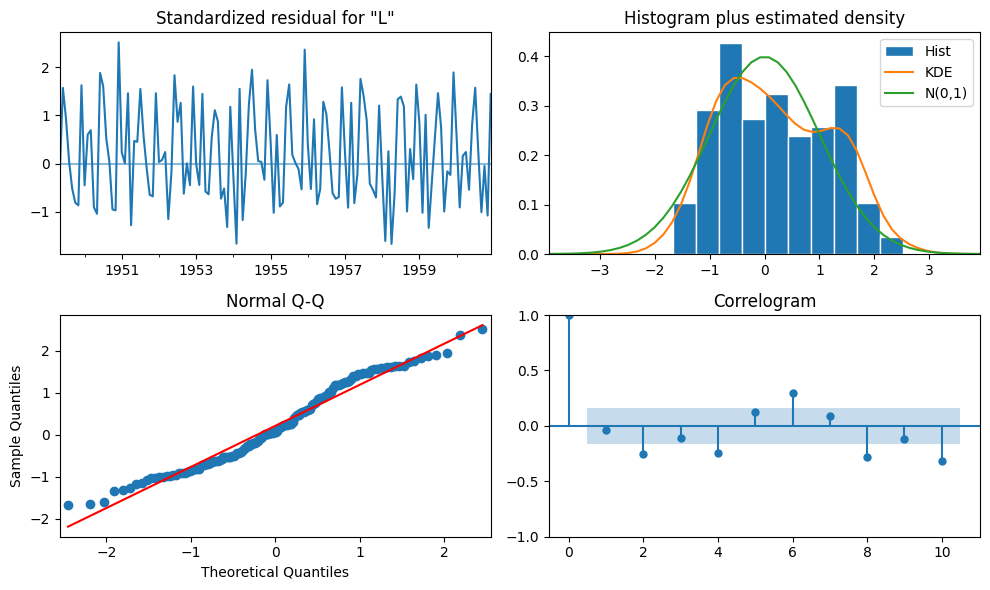

In [76]:
# Model Diagnostics

model_fit.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

### Step 4: Forecast Future Passenger Counts
* Forecast the next 12 months and revert to the original scale.
* Define the future time index.
* Create the future indiex
* Return the shape of 'future_dates'

In [77]:
# CodeGrade step4

# Forecast next 12 months
forecast = model_fit.get_forecast(steps=12)

# Convert back from log scale
forecast_exp = np.exp(forecast.predicted_mean)

# Create future index
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1),
                             periods=12, freq='MS')

future_dates.shape

(12,)

Plot predictions vs actual data.

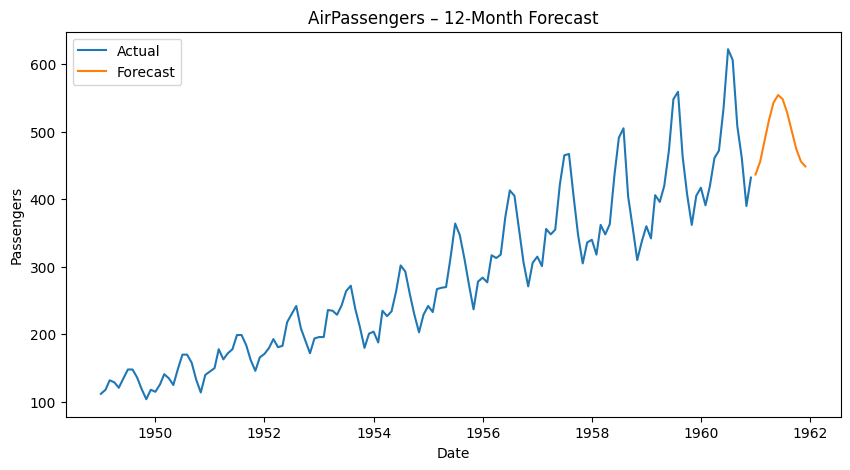

In [78]:
# Plot predictions

plt.figure(figsize=(10,5))
plt.plot(data.index, np.exp(data['Log_Passengers']), label='Actual')
plt.plot(future_dates, forecast_exp, label='Forecast')
plt.title('AirPassengers – 12-Month Forecast')
plt.xlabel('Date'); plt.ylabel('Passengers')
plt.legend(); plt.show()

### Step 5: Evaluate the Model’s Performance
* Compute Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).
* When computing these two values also round them to four decimal places
* Return 'mae, rmse'

In [79]:
# CodeGrade step5

# Get in-sample predictions
predictions = model_fit.get_prediction(start=data.index[1])  # Get predictions for the original time series range
# Instead of dropping the first value, align the predictions with true_values:
true_values = np.exp(data.loc[predictions.predicted_mean.index, 'Log_Passengers'])
# predictions = predictions[true_values.index]  # Align predictions with true_values index
predictions = np.exp(predictions.predicted_mean)

# Calculate error metrics
mae = round(mean_absolute_error(true_values, predictions), 4)
rmse = round(np.sqrt(mean_squared_error(true_values, predictions)), 4)

mae, rmse

(61.2308, np.float64(482.6575))